In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, BertModel
from tqdm import tqdm

from collections import defaultdict, namedtuple
from sklearn.metrics import accuracy_score, f1_score

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DEVICE

device(type='cuda')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [5]:
data_df = pd.read_csv('IMDB Dataset.csv')

In [6]:
MAX_LEN = 512
PAD_INDEX = 0
BATCH_SIZE = 8

In [7]:
def tokenize(text):
    token = torch.tensor(tokenizer(text, truncation=True)['input_ids'])
    # колхозные паддинги
    padded_token = torch.cat((token, torch.zeros(MAX_LEN - token.shape[0])), 0)
    return padded_token

In [8]:
data = list(zip(
    list(map(tokenize, data_df['review'])),
    list(map(lambda sent: 0 if sent == 'negative' else 1, data_df['sentiment'])),
))

In [9]:
train = data[:-5000]
print(len(train))
test = data[-5000:]
print(len(test))

45000
5000


In [10]:
# проверяем, что паддинги сработали корректно
all(map(lambda t: t[0].shape[0] == MAX_LEN, train))

True

In [11]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE)

In [12]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

In [13]:
model = AutoModel.from_pretrained("bert-base-uncased").to(DEVICE)

In [14]:
# нам не нужно, чтобы берт обучался
for p in model.parameters():
    p.requires_grad = False

In [15]:
class Classifier(torch.nn.Module):
    def __init__(self, bert, hidden_size=768, output_size=2):
        super().__init__()
        self.bert = bert
        self.classifier = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        pred = self.bert(x, attention_mask=(x!=0))
        return self.classifier(pred.pooler_output)

In [16]:
criterion = torch.nn.CrossEntropyLoss()
# [размерность_выхода_берта, количество_классов]
classifier = Classifier(model).to(DEVICE)
optimizer = torch.optim.Adam(classifier.classifier.parameters(), lr=1e-3)

In [17]:
EPOCHS = 6

In [18]:
metrics = namedtuple(
    'M', ['train', 'test']
)(defaultdict(list), defaultdict(list))



for e in range(EPOCHS):
    print(f'Epoch: {e}')
    classifier.train()
    for x, y in tqdm(train_loader):
        x = x.long().to(DEVICE)
        y = y.to(DEVICE)
        pred = classifier(x)
        train_loss = criterion(pred, y)
        train_loss.backward()
        metrics.train['loss'].append(train_loss.item())
        metrics.train['accuracy'].append(
            accuracy_score(y.cpu(), torch.argmax(pred, dim=1).cpu())
        )
        metrics.train['f1'].append(
            f1_score(y.cpu(), torch.argmax(pred, dim=1).cpu(), average='micro')
        )
        optimizer.step()
        optimizer.zero_grad()
    if len(metrics.train['loss']) > 4:
        print(np.mean(metrics.train['loss'][4:]))
    classifier.eval()
    for x, y in tqdm(test_loader):
        x = x.long().to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            pred = classifier(x)
        test_loss = criterion(pred, y)
        metrics.test['loss'].append(test_loss.item())
        metrics.test['accuracy'].append(
            accuracy_score(y.cpu(), torch.argmax(pred, dim=1).cpu())
        )
        metrics.test['f1'].append(
            f1_score(y.cpu(), torch.argmax(pred, dim=1).cpu(), average='weighted')
        )
    torch.save(classifier.state_dict(), f'epoch_{e}_classifier.pth')

  0%|          | 0/5625 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/625 [00:00<?, ?it/s]

0.5003923021655896


 12%|█▏        | 73/625 [00:45<05:44,  1.60it/s]/home/misha/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 84%|████████▍ | 524/625 [05:27<01:03,  1.60it/s]/home/misha/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
  0%|          | 0/5625 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/625 [00:00<?, ?it/s]

0.4685358600116234


  0%|          | 0/5625 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/625 [00:00<?, ?it/s]

0.45260070776685546


  0%|          | 0/5625 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/625 [00:00<?, ?it/s]

0.44272738033001463


  0%|          | 0/5625 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/625 [00:00<?, ?it/s]

0.43577322145119657


  0%|          | 0/5625 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/625 [00:00<?, ?it/s]

0.4308066030313825


100%|██████████| 625/625 [06:29<00:00,  1.60it/s]


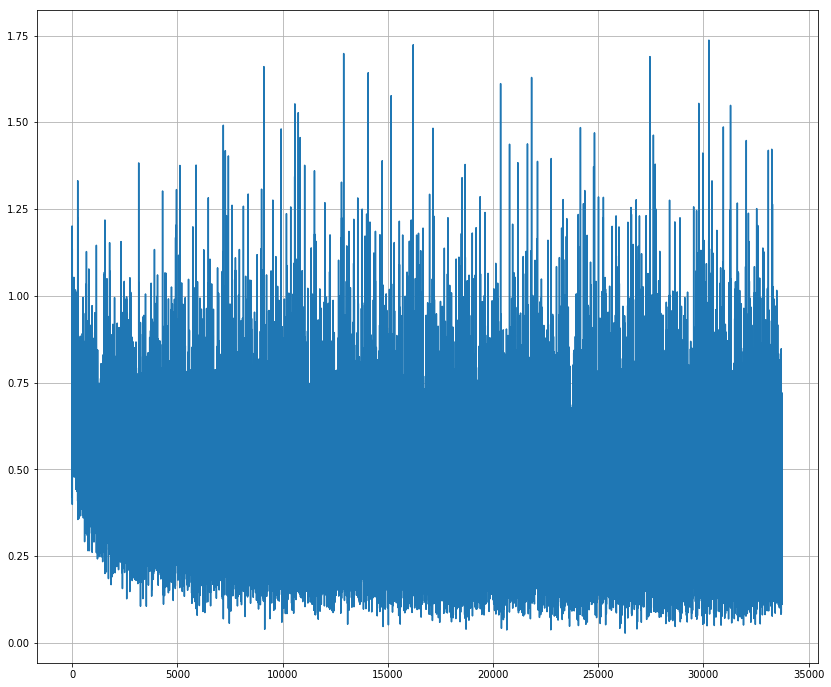

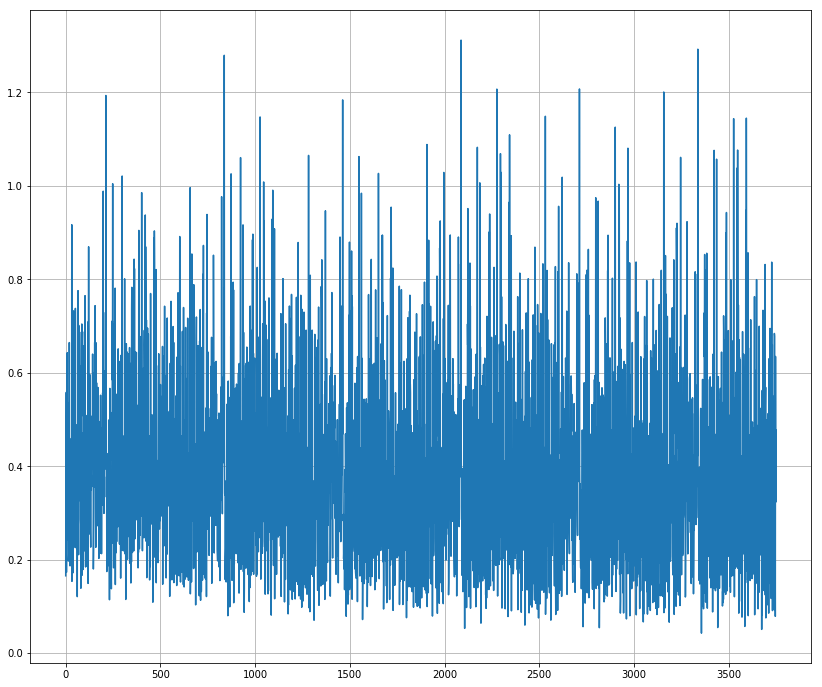

In [21]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(metrics.train['loss'])
plt.grid()
plt.figure(figsize=(14, 12))
plt.plot(metrics.test['loss'])
plt.grid()

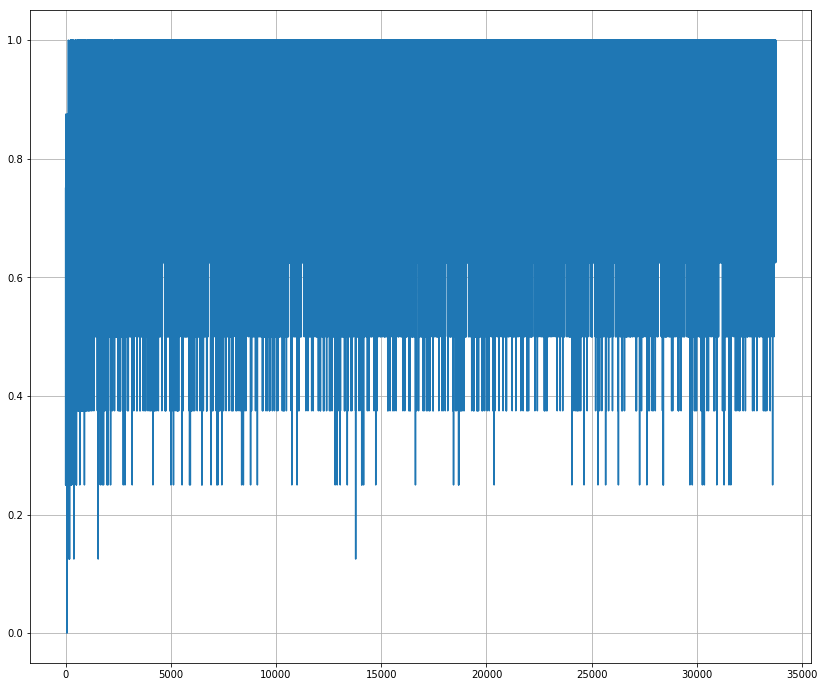

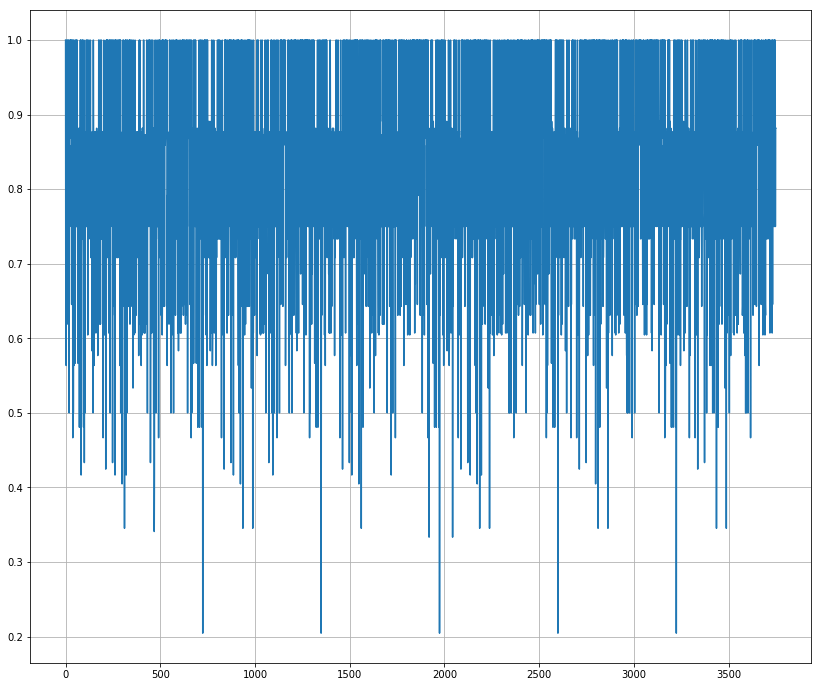

In [22]:
plt.figure(figsize=(14, 12))
plt.plot(metrics.train['f1'])
plt.grid()
plt.figure(figsize=(14, 12))
plt.plot(metrics.test['f1'])
plt.grid()

In [23]:
print('Метрики на последней эпохе')
print('Accuracy train: ', np.mean(metrics.train['accuracy'][-5625:]))
print('F1 train: ', np.mean(metrics.train['f1'][-5625:]))
print('Accuracy test: ', np.mean(metrics.train['f1'][-625:]))
print('F1 test: ', np.mean(metrics.train['f1'][-625:]))

Метрики на последней эпохе
Accuracy train:  0.8158222222222222
F1 train:  0.8158222222222222
Accuracy test:  0.8144
F1 test:  0.8144
